# XGBoost implementation

In [100]:
# Packages and libraries
import pandas as pd
import xgboost as xgb

In [101]:
# XGBoost data prep
#remove white space in columns
#NOTE: GENDER_bin=1 is female and GENDER_bin=0 is males

df = pd.read_csv("df_sum_score_py.csv")
df.replace(' ','_',regex=True,inplace=True)

# there were 14 missing values, which has earlier been set to 0 in STRATUM. 
# Since this is only approximately 0.116% of the entire data, we do not need to do anything further. 
# XGBoost is very well at handling missing data, and we just need to ensure that it's set to 0. 
df.STRATUM.isin(['0']).sum()

14

In [102]:
# Splitting the data 
# X is the data which will be used to make predictions, and y contains the data we want to predict.
# We want to predict the score of the students in college, hence y_training and y_test is the college average grade. 

X = df.drop(['COL_GRADE_AVG','GENDER','Unnamed: 0','CR_S11','CC_S11','ENG_S11','CR_PRO','CC_PRO','ENG_PRO'], axis=1).copy()
y=df['COL_GRADE_AVG'].copy()

# Now we will continue to formatting X to make it suitable for making a model with XGBoost. 

In [103]:
# One-hot encoding 

# Look at the different types of data contained in each variable. 
X.dtypes

# The object columns we need to inspect to ensure that they are what we need them to be and after that we will do one-hot encoding. 
# One hot encoding is used to make the categorical varoiable STRATUM work in the model. 
# What is gonna happen is that the categorical variable is becoming multiple columns of binary values. 
# One hot encoding works great for trees and this is the motivation for using this method. 
X_encoded = pd.get_dummies(X,columns=['STRATUM'])


In [104]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_encoded,y,random_state=24, test_size=0.33)#, stratify=y)

In [105]:
# fra horse tut
# frames = [X_train, y_train]

# train_data = pd.concat([X_train, y_train], axis=1)
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train) 
data_dmatrix

# Regressor

In [106]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt 

In [107]:
# XGBRegressor

model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

TODO
- vi vil gerne lave parameter approximations med cross valdiation. Se eventuelt denne video https://www.youtube.com/watch?v=GrJP9FLV3FE
- 

In [9]:
# scores = cross_val_score(model, X_train, y_train, cv=10)
# print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: 0.56


# Prediction

In [16]:
y_pred = model.predict(X_test)
y_pred


array([86.15838 , 84.907745, 86.89197 , ..., 91.33312 , 76.757935,
       59.32007 ], dtype=float32)

# Mean squared error
This is the average squared difference between the estimated values and the actual value.

In [109]:
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse)

MSE: 219.97
RMSE: 14.83


# Optimize parameters using cross-validation

XGBoost has a lot of hyper parameters which we can manually tune. These are e.g. max_depth of the tree, learning_rate, gamma which encourages pruning of the tree and reg_lambda which is the regularization parameter lambda. We are trying to find the optimal values for these parameters and hope that we can improve the accuracy in the prediction of the candidates college grades. 

# Gridsearch cross validation 

Gridsearch CV will be run sequentially on subsets of different options for the parameters. 


In [110]:
# 1st round
param_grid_1 = {
    'max_depth':[3,4,5],
    'learning_rate':[0.01,0.05,0.1],
    'gamma':[0,0.25,0.1],
    'reg_lambda':[0,0.1,10.0],
    'scale_pos_weight':[1,3,5]
}

In [111]:
from sklearn.model_selection import GridSearchCV


# base_estimator_model = xgb.XGBRegressor()
# clf = GridSearchCV(base_estimator_model, param_grid)
# clf.fit(X_train, y_train)

optimal_params = GridSearchCV(
    estimator=xgb.XGBRegressor(
        objective='reg:squarederror', seed=24, subsample=0.9),
        param_grid=param_grid_1,
        cv=5).fit(X_train,y_train)
          

In [112]:
# optimal parameters 
print(optimal_params.best_params_)


{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'reg_lambda': 10.0, 'scale_pos_weight': 1}


In [113]:
## Round 2 
param_grid_2 = {
    'max_depth':[2,3],
    'learning_rate':[0.05],
    'gamma':[0,0.01],
    'reg_lambda':[10.0,15.0,20.0],
    'scale_pos_weight':[0.01,0.5,1]
}

In [114]:
optimal_params = GridSearchCV(
    estimator=xgb.XGBRegressor(
        objective='reg:squarederror', seed=24, subsample=0.9),
        param_grid=param_grid_2,
        cv=5).fit(X_train,y_train)

In [115]:
# optimal parameters 
print(optimal_params.best_params_)

{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'reg_lambda': 15.0, 'scale_pos_weight': 0.01}


In [116]:
## Round 3 
param_grid_3 = {
    'max_depth':[3],
    'learning_rate':[0.05],
    'gamma':[0],
    'reg_lambda':[15.0],
    'scale_pos_weight':[0.01]
}

In [117]:
final_model = xgb.XGBRegressor(seed=24, objective='reg:squarederror', max_depth=3, learning_rate=0.05, gamma=0,reg_lambda=15.0, scale_pos_weight=0.01)
final_model.fit(X_train,y_train,verbose=True, eval_metric='rmse')
# eval_metric default according to objective

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=24,
             reg_alpha=0, reg_lambda=15.0, scale_pos_weight=0.01, seed=24,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [118]:
scores_final = cross_val_score(final_model, X_train, y_train, cv=10)
print("Mean cross-validation score: %.2f" % scores_final.mean())

scores = cross_val_score(model, X_train, y_train, cv=10)
# print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: 0.60


In [119]:
y_pred_final = final_model.predict(X_test)
y_pred_final

array([86.0275 , 85.41487, 85.96548, ..., 86.64408, 75.97237, 61.03375],
      dtype=float32)

In [124]:
# Kør disse herunder for at se om det er blevet bedre 
mse_final = mean_squared_error(y_test, y_pred_final)
print("FINAL MSE: %.2f" % mse_final)

# Root mean squared error
rmse_final= np.sqrt(mse_final)
print("FINAL RMSE: %.2f" % rmse_final)


FINAL MSE: 205.79
FINAL RMSE: 14.35


Before and after parameter optimization
MSE: 219.97
RMSE: 14.83

FINAL MSE: 205.79
FINAL RMSE: 14.35

## Plotting the tree? 
concider plotting the tree

Muligvis skal vitage og concat y_test.index og y_pred for at få index på predictions. Så vi kan sorte dem og se om der er en bestemt tendens. 

In [121]:
# Prøve at sorte predictions med mergesort 
import numpy as np

pred_sorted = np.sort(y_pred_final, axis=- 1, kind='mergesort')[::-1]
pred_sorted


array([93.66171 , 93.66171 , 93.66171 , ..., 22.908688, 22.679869,
       22.679869], dtype=float32)

# Plotting

In [122]:
import matplotlib as mpl
def setup_mpl():
    mpl.rcParams["font.family"] = "Helvetica Neue"
    mpl.rcParams["font.size"] = 11
    mpl.rcParams["figure.figsize"] = (10,5)
    mpl.rcParams["figure.dpi"] = 200
    # mpl.rcParams["lines.linewidth"] = 1
setup_mpl()

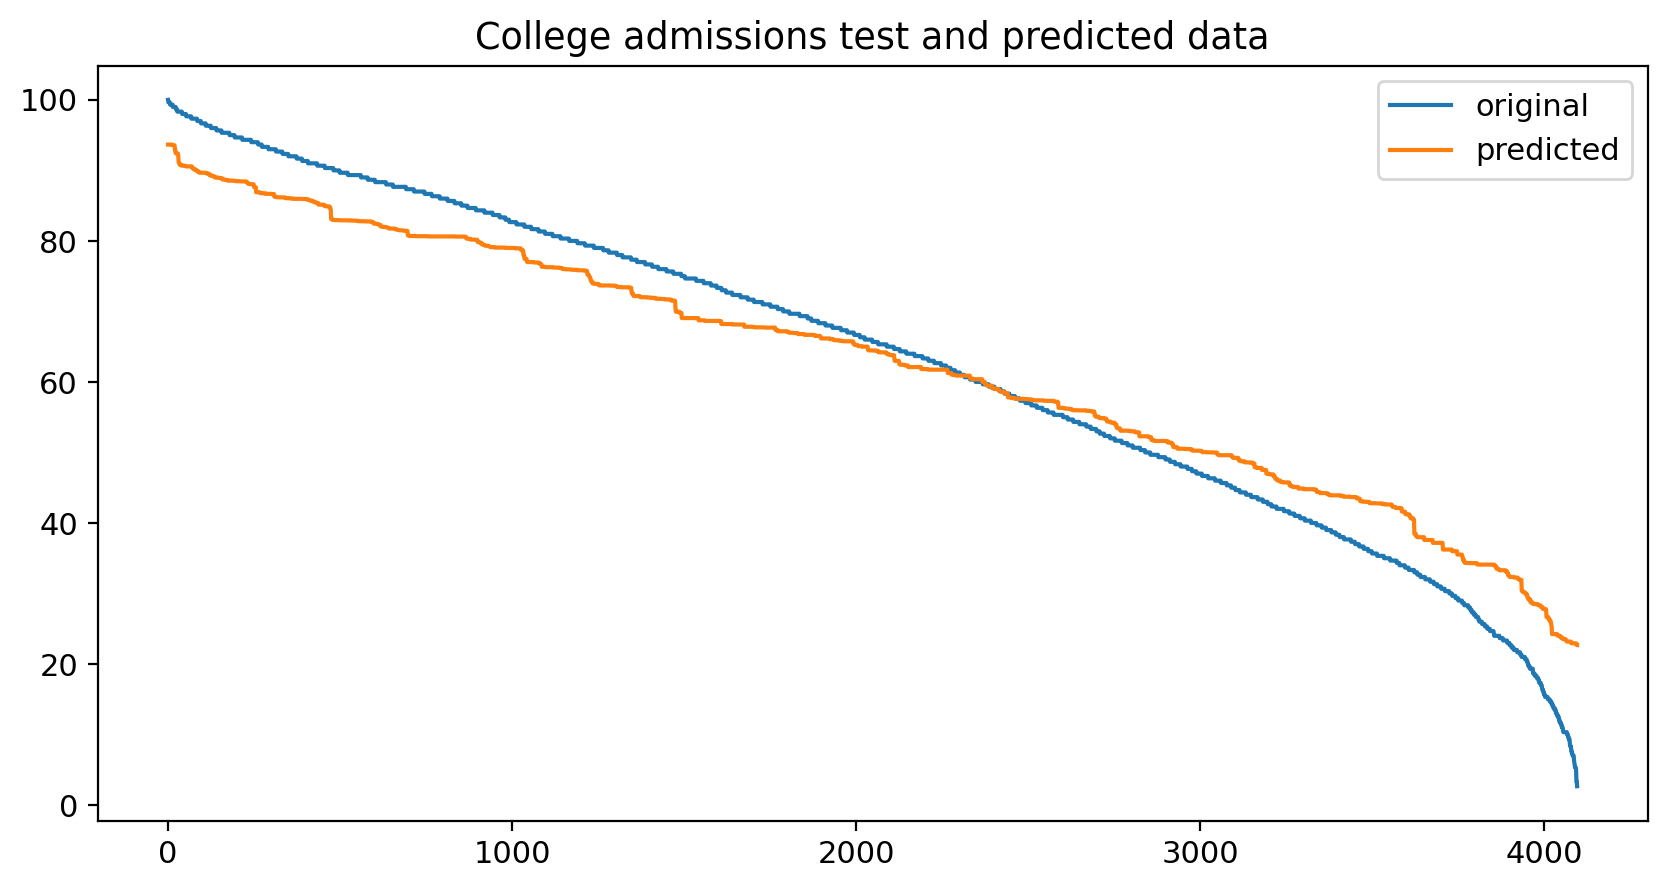

In [123]:

x_ax = range(len(y_test))
y_test_sorted = np.sort(y_test, axis=- 1, kind='mergesort')[::-1]
plt.plot(x_ax, y_test_sorted, label="original")
plt.plot(x_ax, pred_sorted, label="predicted")
plt.title("College admissions test and predicted data")
plt.legend()
plt.show()

In [ ]:
Nu når jeg har optimeret parametre 